<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/3%20action%20deep%20q%20regularized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
!pip install pandas_ta
!pip install tf_agents[reverb]


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import reverb
import random

import tensorflow as tf

from tensorflow.keras import layers
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

2023-08-25 23:46:05.025208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
num_iterations = 2000000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 3  # @param {type:"integer"}
eval_interval = 10000  # @param {type:"integer"}

In [4]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [5]:
df = pd.read_csv('/tmp/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


In [6]:
RSI = ta.rsi(close,14,scalar=1)
AROON = ta.aroon(high,low,14,scalar = 1)
AROON_UP = AROON['AROOND_14']
AROON_DOWN = AROON['AROONU_14']
CCI = ta.cci(high,low,close,14)
CCI = CCI.multiply(.001)
CCI = CCI.add(.5)
RVI = ta.rvi(close,high,low,14,scalar=1)
CHANGE = get_relative_change(close,"Change")
INDICATORS = pd.concat([CHANGE,RSI,AROON_UP,AROON_DOWN,CCI,RVI],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()

change = INDICATORS.pop('Change')
INDICATORS.pop('index')

INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev
np.set_printoptions(suppress=True)
print(change)

[-1.99453945  1.27757318 -0.7972413  ...  0.36195025 -0.31656675
 -0.04524129]


In [7]:
print(INDICATORS)

[[0.38187407 1.         0.71428571 0.39334634 0.85330187]
 [0.52438576 0.92857143 0.64285714 0.42260631 0.87272338]
 [0.45394255 0.85714286 0.57142857 0.38867102 0.75057577]
 ...
 [0.63073968 0.42857143 0.85714286 0.63507997 0.67330809]
 [0.60441535 0.35714286 0.78571429 0.61566583 0.57482093]
 [0.60055924 0.28571429 0.71428571 0.59201605 0.48856795]]


(5400.0, 5500.0)

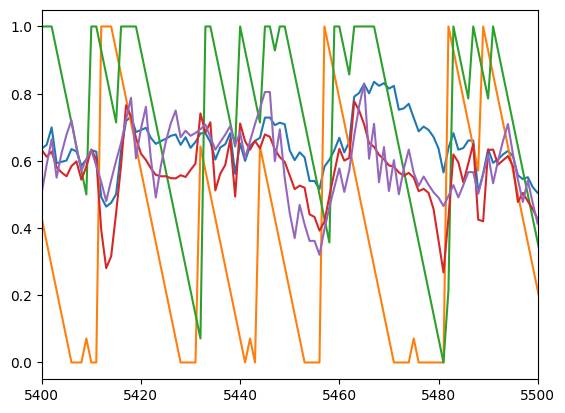

In [8]:
plt.plot(INDICATORS)
plt.xlim(5400,5500)
#print(INDICATORS)

In [9]:
max_ep_len = 1000

In [10]:
class TradingEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int64, minimum=0, maximum=2, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(5,), dtype=np.float32, minimum=-100,maximum=100, name='observation')


    self._state = INDICATORS[0]
    self._episode_ended = False  
    self._balance = 0
    self._blown = False
    self._actions = [0,0,0]
    self._count = random.randint(0,60000)
    self._end_ep = self._count+max_ep_len


  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):

    self._state = INDICATORS[0]
    self._episode_ended = False    
    self._balance = 0
    self._blown = False
    self._actions = [0,0,0]
    self._count = random.randint(0,60000)
    self._end_ep = self._count+max_ep_len

    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    no_trade = True if action == 0 else False
    buy = True if action == 1 else False
    sell = True if action == 2 else False
    attrition_val = .1
    offset = 100/attrition_val



    if buy:
        profit = change[self._count]
        self._actions[0] = 1
    elif sell:
        profit = change[self._count]*-1
        self._actions[1] = 1
    elif no_trade:
        profit = 0
        self._actions[2] = 1

    self._balance += profit


    if self._balance < -100:
      self._blown = True


    #update state
    self._state = INDICATORS[self._count]

    if self._count >= self._end_ep or self._blown:
      self._episode_ended = True

    self._count += 1
    self._prev_action = action

    if self._episode_ended:
      reward = self._balance if sum(self._actions) == 3 else -1000
      return ts.termination(np.array(self._state, dtype=np.float32), reward=reward)
    else:
      reward = profit# if profit > 0 else 0
      return ts.transition(
          np.array(self._state, dtype=np.float32), reward=reward, discount=.99)

In [11]:
env = TradingEnv()

utils.validate_py_environment(env, episodes=2)

In [12]:
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [13]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


In [14]:
fc_layer_params = (20, 5)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1


In [15]:
def lars_regularizer(lars_coefficient):
    def regularizer(y_true, y_pred):
        # Get the mean and variance of the layer's output
        output_mean = tf.reduce_mean(y_pred)
        output_variance = tf.reduce_variance(y_pred)

        # Calculate the LARS penalty
        lars_penalty = lars_coefficient * (output_variance - tf.square(output_mean))

        return lars_penalty

    return regularizer

In [16]:
class LARSRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, lars_coefficient, momentum=0.9):
        self.lars_coefficient = lars_coefficient
        self.momentum = momentum
        self.mean_ema = tf.Variable(0.0, trainable=False)
        self.variance_ema = tf.Variable(0.0, trainable=False)

    def __call__(self, y_pred):
        # Calculate the mean and variance of the layer's output
        output_mean = tf.reduce_mean(y_pred)
        output_variance = tf.math.reduce_variance(y_pred)

        # Update the moving averages with momentum
        self.mean_ema.assign(self.momentum * self.mean_ema + (1.0 - self.momentum) * output_mean)
        self.variance_ema.assign(self.momentum * self.variance_ema + (1.0 - self.momentum) * output_variance)

        # Calculate the LARS penalty using the moving averages
        lars_penalty = self.lars_coefficient * (output_variance - tf.square(output_mean))

        return lars_penalty

In [17]:
drop_val = .2
lars_coefficient = .01
q_net = sequential.Sequential([
    layers.Dense(30,activation='gelu',activity_regularizer=LARSRegularizer(lars_coefficient)),
    layers.Dropout(drop_val),
    layers.Dense(30,activation='gelu',activity_regularizer=LARSRegularizer(lars_coefficient)),
    layers.Dropout(drop_val),
    layers.Dense(30,activation='gelu',activity_regularizer=LARSRegularizer(lars_coefficient)),
    layers.Dropout(drop_val),
    layers.Dense(num_actions,activation=None)
])

2023-08-25 23:46:09.841883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-25 23:46:09.845501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-25 23:46:09.845680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [19]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [20]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [21]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [22]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

58.678707

In [23]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpy6tc11od.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpy6tc11od
[reverb/cc/platform/default/server.cc:71] Started replay server on port 33651


In [24]:
agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [25]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0.99, dtype=float32),
  'observation': array([0.5680308 , 0.64285713, 1.        , 0.67140883, 0.5758139 ],
       dtype=float32),
  'reward': array(1.0871884, dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [26]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 5), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [27]:
iterator = iter(dataset)
print(iterator)

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 1000: loss = 0.9834122061729431
step = 2000: loss = 0.8152973651885986
step = 3000: loss = 0.5741444230079651
step = 4000: loss = 1.2476954460144043
step = 5000: loss = 0.7034497261047363
step = 6000: loss = 0.7925626039505005
step = 7000: loss = 0.3360763490200043
step = 8000: loss = 0.9605780243873596
step = 9000: loss = 0.9910489320755005
step = 10000: loss = 1.6160365343093872
step = 10000: Average Return = -303.38055419921875
step = 11000: loss = 0.35727986693382263
step = 12000: loss = 0.8949363827705383
step = 13000: loss = 1.1135121583938599
step = 14000: loss = 0.5612014532089233
step = 15000: loss = 1.9329890012741089
step = 16000: loss = 0.28535810112953186
step = 17000: loss = 0.4485161602497101
step = 18000: loss = 0.6808467507362366
step = 19000: loss = 2.0641167163848877
step = 20000: loss = 1.208182454109192
step = 20000: Average Return = 36.53525161743164
step = 21000: loss = 1.6018470525741577
step = 22000: loss = 1.104042410850525
step = 23000: loss = 0.653708

In [ ]:
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
print(avg_return)

In [31]:
weights = q_net.get_weights()
print(weights)

[array([[-0.5081186 ,  0.8910481 ,  1.5579158 , -0.7359219 , -1.2887543 ,
         1.2286294 ,  0.05555091,  0.25312564, -1.4376432 , -0.65608513,
         0.778167  , -1.3340681 ,  1.6253657 ,  0.86711866, -0.21969685,
         0.38583076,  0.96660095,  0.5406268 , -1.270037  ,  0.37615633,
         1.1246289 , -1.2812654 ,  1.8337646 ,  1.4268904 ,  1.620492  ,
        -1.564764  , -0.9238403 ,  1.5670117 ,  1.53147   , -1.3397356 ],
       [ 0.46112928,  0.00216156,  0.07400567,  0.33360893, -0.23292507,
         0.4124851 ,  0.3531649 , -3.1483502 , -0.32700238, -2.0679438 ,
        -0.11391673,  0.10283688,  0.46769476, -0.20028321, -0.06217593,
        -0.5277927 , -0.0122525 , -1.5033795 ,  0.47171828,  0.3353168 ,
         0.22427392, -0.09324773, -0.71901476,  0.17020993, -0.00624603,
        -0.45833236, -0.30997476,  0.03361753,  0.13985386, -0.5501212 ],
       [ 0.46717253,  1.4629071 , -0.3127719 ,  0.81622666, -0.45173585,
        -0.12502639, -0.1874877 ,  0.8437775 , -